In [5]:
import numpy as np
import pandas as pd
import numba

# Unsteady flow : Collocated

In [6]:
@numba.jit(nopython=True, parallel=False)
def UnSteadyflowCollocated(A, Q, Adown, Qup, zb, B, dx, dt, g, manning):
    imax = len(A)
    Anew, Qnew = np.zeros(imax), np.zeros(imax)
    
# continuous equation
    for i in numba.prange(1, imax-1) : Anew[i] = A[i] - dt * ( Q[i] - Q[i-1] ) / dx
        
    Anew[0], Anew[-1] = Anew[1], Adown
    
# moumentum equation
    for i in numba.prange(1,imax-1): 
        ip, ic, im = (i+1, i, i-1) 
        Cr1 = 0.5*( Q[ic]/A[ic] + Q[ip]/A[ip] )*dt/dx
        Cr2 = 0.5*( Q[ic]/A[ic] + Q[im]/A[im] )*dt/dx
        dHdx1 = ( Anew[ip]/B[ip] + zb[ip] - Anew[ic]/B[ic] - zb[ic] ) / dx
        dHdx2 = ( Anew[ic]/B[ic] + zb[ic] - Anew[im]/B[im] - zb[im] ) / dx
        dHdx = (1.0 - Cr1) * dHdx1 + Cr2 * dHdx2
        
        Qnew[ic] = Q[ic] - dt * ( Q[ic]**2/A[ic] - Q[im]**2/A[im] ) / dx  \
                   - dt * g * Anew[ic] * dHdx \
                   - dt * g * A[ic] * manning**2 * Q[ic]**2 / B[ic]**2 / ( A[ic]/B[ic] )**(10.0/3.0)
                
#     Qnew[0], Qnew[-1] = Qup, Qnew[-2]
    Qnew[0] = Qup
    
# check downstream boundary Q 
    i = -1
    ic, im = (i, i-1) 
    dHdx = ( Anew[ic]/B[ic] + zb[ic] - Anew[im]/B[im] - zb[im] ) / dx
    
    Qnew[ic] = Q[ic] - dt * ( Q[ic]**2/A[ic] - Q[im]**2/A[im] ) / dx  \
               - dt * g * Anew[ic] * dHdx \
               - dt * g * A[ic] * manning**2 * Q[ic]**2 / B[ic]**2 / ( A[ic]/B[ic] )**(10.0/3.0)
            
    return Anew, Qnew, np.abs(Anew - A).max()

In [8]:
df = pd.read_csv('zb2.csv',index_col=0)

In [12]:
q = 10.0
n = 0.03
ib = 1/400
g = 9.8

h0 = (q**2*n**2/ib)**0.3 #等流水深
hc = (q**2/g)**(1/3) # 限界水深

In [13]:
%%time

dx = 0.5
Ls1 = np.arange(0,10000.1,dx)
Zip1 = np.interp(Ls1, df.L, df.Z)

imax = len(Ls1)
dt = 0.025
totalTime = 3.0*3600.0
manning = n

# Initial & Boundary condition
zb = Zip1.copy()
zb = zb[::-1]

B = np.full(imax, 1.0, dtype=float)
A = h0*B
Q = q*B

Qup = Q[0]
Adown = A[-1] 

tout = 600
for it in range(int(totalTime/dt)):
    A, Q, err = UnSteadyflowCollocated(A, Q, Adown, Qup, zb, B, dx, dt, g, manning)
    if (dt*it)%tout==0: print((dt*it), err)
        
hc1 = A[::-1]/B[::-1] 

0.0 0.0
600.0 1.0122798015377299e-05
1200.0 6.57282393046188e-06
1800.0 4.625407031166873e-06
2400.0 1.2862340690311669e-06
3000.0 2.2916509667680884e-07
3600.0 3.340312026978154e-08
4200.0 4.342391335399043e-09
4800.0 5.254690016442964e-10
5400.0 6.063327617766845e-11
6000.0 6.7696959149543545e-12
6600.0 7.385203559806541e-13
7200.0 7.949196856316121e-14
7800.0 8.881784197001252e-15
8400.0 1.3322676295501878e-15
9000.0 1.3322676295501878e-15
9600.0 1.3322676295501878e-15
10200.0 1.3322676295501878e-15
CPU times: total: 4min 55s
Wall time: 5min 16s


In [14]:
%%time

dx = 10.0
Ls2 = np.arange(0,10000.1,dx)
Zip2 = np.interp(Ls2, df.L, df.Z)

imax = len(Ls2)
dt = 0.025
totalTime = 3.0*3600.0
manning = n

# Initial & Boundary condition
zb = Zip2.copy()
zb = zb[::-1]

B = np.full(imax, 1.0, dtype=float)
A = h0*B
Q = q*B

Qup = Q[0]
Adown = A[-1] 

tout = 600
for it in range(int(totalTime/dt)):
    A, Q, err = UnSteadyflowCollocated(A, Q, Adown, Qup, zb, B, dx, dt, g, manning)
    if (dt*it)%tout==0: print((dt*it), err)
        
hc2 = A[::-1]/B[::-1] 

0.0 0.0
600.0 7.317613084367736e-07
1200.0 4.206980599441579e-07
1800.0 2.7017321535538485e-07
2400.0 6.685291964458884e-08
3000.0 1.0595971211557753e-08
3600.0 1.3531029630087232e-09
4200.0 1.5262990871178772e-10
4800.0 1.5917489548655794e-11
5400.0 1.574740338128322e-12
6000.0 1.5010215292932116e-13
6600.0 1.4210854715202004e-14
7200.0 1.3322676295501878e-15
7800.0 0.0
8400.0 0.0
9000.0 0.0
9600.0 0.0
10200.0 0.0
CPU times: total: 15.4 s
Wall time: 15.5 s


In [15]:
%%time

dx = 100.0
Ls3 = np.arange(0,10000.1,dx)
Zip3 = np.interp(Ls3, df.L, df.Z)

imax = len(Ls3)
dt = 0.025
totalTime = 3.0*3600.0
manning = n

# Initial & Boundary condition
zb = Zip3.copy()
zb = zb[::-1]

B = np.full(imax, 1.0, dtype=float)
A = h0*B
Q = q*B

Qup = Q[0]
Adown = A[-1] 

tout = 600
for it in range(int(totalTime/dt)):
    A, Q, err = UnSteadyflowCollocated(A, Q, Adown, Qup, zb, B, dx, dt, g, manning)
    if (dt*it)%tout==0: print((dt*it), err)
        
hc3 = A[::-1]/B[::-1] 

0.0 0.0
600.0 3.880656556098927e-07
1200.0 9.943363998843324e-08
1800.0 6.444170885799849e-08
2400.0 1.8708917970400307e-08
3000.0 3.435093542947243e-09
3600.0 5.156124416316743e-10
4200.0 6.938360996855408e-11
4800.0 8.739231560639382e-12
5400.0 1.0547118733938987e-12
6000.0 1.234568003383174e-13
6600.0 1.4210854715202004e-14
7200.0 1.3322676295501878e-15
7800.0 0.0
8400.0 0.0
9000.0 0.0
9600.0 0.0
10200.0 0.0
CPU times: total: 2.44 s
Wall time: 2.49 s


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
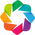

In [16]:
import holoviews as hv
hv.extension('bokeh')

In [17]:
fig = hv.Curve((df.L,df.Z), label='Zb dx=0.5m').options(show_grid=True, ylabel='elevation[m]', xlabel='distance[m]' ,color='k') \
* hv.Scatter((Ls2, Zip2), label='Zb dx=10m').options(color='r',size=6) \
* hv.Scatter((Ls3, Zip3), label='Zb dx=100m').options(color='g',size=6) \
* hv.Curve((Ls1, Zip1 + hc1), label='dx=0.5m' ).options(color='b') \
* hv.Curve((Ls2, Zip2 + hc2), label='dx=10m').options(color='r') \
* hv.Curve((Ls3, Zip3 + hc3), label='dx=100m').options(color='g')

In [18]:
figo = fig.options(width=500, legend_position='bottom_right')
d = hv.save(figo, 'USCdx.html')
figo 

:Overlay
   .Curve.Zb_dx_equals_0_full_stop_5m :Curve   [x]   (y)
   .Scatter.Zb_dx_equals_10m          :Scatter   [x]   (y)
   .Scatter.Zb_dx_equals_100m         :Scatter   [x]   (y)
   .Curve.Dx_equals_0_full_stop_5m    :Curve   [x]   (y)
   .Curve.Dx_equals_10m               :Curve   [x]   (y)
   .Curve.Dx_equals_100m              :Curve   [x]   (y)

In [19]:
figo2 = fig.options(xlim=(3050, 3350), ylim=(7, 12), width=700, height=600, legend_position='right')
d = hv.save(figo2, 'USCdx2.html')
figo2

:Overlay
   .Curve.Zb_dx_equals_0_full_stop_5m :Curve   [x]   (y)
   .Scatter.Zb_dx_equals_10m          :Scatter   [x]   (y)
   .Scatter.Zb_dx_equals_100m         :Scatter   [x]   (y)
   .Curve.Dx_equals_0_full_stop_5m    :Curve   [x]   (y)
   .Curve.Dx_equals_10m               :Curve   [x]   (y)
   .Curve.Dx_equals_100m              :Curve   [x]   (y)